In [3]:
import numpy as np

# 假设您已经有了 efficiency_history 数组


efficiency_history_file_path = 'dataset/efficiency_history_STARLINK-1094.npy' 

efficiency_history  = np.load(efficiency_history_file_path)

## Write the dictionary to a file in JSON format
#with open(efficiency_history_file_path, 'w') as file:
#    json.dump(efficiency_history, file)

In [11]:
import json
import os

sat2stat_file_path = os.path.join("dataset", "sat2stat_efficiency.json")


# Write the dictionary to a file in JSON format
with open(sat2stat_file_path, 'r') as file:
    communication_efficiency_sat2stat = json.load(file)
    
    
sat2sat_file_path = os.path.join("dataset", "sat2sat_efficiency.json")


# Write the dictionary to a file in JSON format
with open(sat2sat_file_path, 'r') as file:
    communication_efficiency_sat2sat = json.load(file)
    

In [12]:
from algorithm.graph import generate_graph, generate_sub_graph, dijkstra_efficiency
#from algorithm.steiner import build_steiner_tree

In [3]:
from collections import defaultdict, deque

def build_steiner_tree(graph, start, ground_stations, excluded_satellites):
    tree = {start}
    tree_edges = []
    remaining_stations = set(ground_stations)

    while remaining_stations:
        distances, paths = multi_source_bfs(graph, tree, excluded_satellites)
        
        # Find the nearest remaining ground station to the tree
        nearest_station = min(remaining_stations, key=lambda x: distances.get(x, float('inf')))
        path_to_nearest = paths.get(nearest_station, [])

        # Add the path to the nearest station to the tree
        for i in range(1, len(path_to_nearest)):
            tree_edges.append((path_to_nearest[i-1], path_to_nearest[i]))
            tree.add(path_to_nearest[i])
        remaining_stations.remove(nearest_station)

    return tree, tree_edges

def multi_source_bfs(graph, sources, excluded_satellites):
    queue = deque(sources)
    visited = {source: 0 for source in sources}  # visited node and distance
    paths = {source: [source] for source in sources}  # the path from source to node

    while queue:
        current = queue.popleft()
        for neighbor in graph[current]:
            if neighbor not in visited and neighbor not in excluded_satellites:
                visited[neighbor] = visited[current] + 1
                paths[neighbor] = paths[current] + [neighbor]
                queue.append(neighbor)
    return visited, paths



In [4]:
threshold = 0.0001
G, ground_stations, satellites = generate_graph(communication_efficiency_sat2stat, communication_efficiency_sat2sat, threshold)

In [5]:
ground_stations = {'Amsterdam',
 'Berlin',
 'Brussels',
 'Chicago',
 'London',
 'Los Angeles',
 'New York',
 'Ottawa',
 'Paris',
 'Washington D.C.'}

In [6]:
start = "New York"
graph = G
excluded_satellites = set()
all_trees = []
all_edges = set()

for _ in range(3):
    tree, tree_edges = build_steiner_tree(G, start, ground_stations, excluded_satellites)
    all_trees.append(tree)
    all_edges.update(tree_edges)  # Update using set.update() to avoid duplicates
    # Exclude satellites used in this iteration
    excluded_satellites.update(tree & satellites)

print("All Tree Nodes:", all_trees)
print("All Tree Edges:", all_edges)

All Tree Nodes: [{'New York', 'Berlin', 'Paris', 'Los Angeles', 'London', 'Ottawa', 'Brussels', 'STARLINK-1971', 'Chicago', 'Amsterdam', 'Washington D.C.', 'STARLINK-1144', 'STARLINK-1054', 'STARLINK-1102'}, {'New York', 'Berlin', 'Paris', 'Los Angeles', 'STARLINK-4197', 'London', 'Ottawa', 'STARLINK-1094', 'Brussels', 'Chicago', 'Amsterdam', 'Washington D.C.', 'STARLINK-1062'}, {'New York', 'Paris', 'Berlin', 'STARLINK-3557', 'Los Angeles', 'London', 'Ottawa', 'STARLINK-1200', 'STARLINK-5212', 'Brussels', 'Chicago', 'Amsterdam', 'STARLINK-1156', 'Washington D.C.'}]
All Tree Edges: {('Paris', 'STARLINK-1200'), ('STARLINK-1094', 'STARLINK-4197'), ('STARLINK-4197', 'London'), ('New York', 'STARLINK-1094'), ('STARLINK-1200', 'Berlin'), ('STARLINK-3557', 'London'), ('STARLINK-1094', 'Ottawa'), ('New York', 'STARLINK-1144'), ('STARLINK-1971', 'London'), ('STARLINK-1102', 'STARLINK-1971'), ('STARLINK-1156', 'Washington D.C.'), ('STARLINK-1156', 'Ottawa'), ('New York', 'STARLINK-1102'), ('STA

In [7]:
optimal_constellation = []
for tree in all_trees:
    for item in tree:
        #print(item)
        if item not in ground_stations:
            optimal_constellation.append(item)

In [8]:
optimal_constellation

['STARLINK-1971',
 'STARLINK-1144',
 'STARLINK-1054',
 'STARLINK-1102',
 'STARLINK-4197',
 'STARLINK-1094',
 'STARLINK-1062',
 'STARLINK-3557',
 'STARLINK-1200',
 'STARLINK-5212',
 'STARLINK-1156']

In [9]:
sub_graph = generate_sub_graph(G, ground_stations, optimal_constellation)

In [10]:
city1 = 'New York'
city2 = 'Washington D.C.'
# Make sure to define your `sub_graph` before calling this function
optimal_path, efficiency = dijkstra_efficiency(sub_graph, city1, city2)
print(f"Optimal path from {city1} to {city2} is: {optimal_path}, efficiency: {efficiency}")


Optimal path from New York to Washington D.C. is: ['New York', 'STARLINK-1144', 'Washington D.C.'], efficiency: 1.5629063975258394e-06


# Simulation

In [20]:
from load_data.get_satellites import satellite, get_satellites
from load_data.get_ground_stations import ground_station, get_ground_station
from load_data.load_tle import parse_tle
from skyfield.api import load
from model.distribution_efficiency_sat2sat import communication_loss_sat2sat
from model.distribution_efficiency_stat2sat import communication_loss_stat2sat

In [2]:
tle_path = './dataset/satellite_tle.txt'
satellite_tle_data = parse_tle(tle_path)
ts = load.timescale()
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
ground_stations_entity = get_ground_station()

In [3]:
optimal_constellation_entity = {}
for sat_name, tle in satellite_tle_data.items():
    if sat_name in optimal_constellation:
        optimal_constellation_entity[sat_name] = satellite(sat_name, tle[0], tle[1], specific_time)

NameError: name 'optimal_constellation' is not defined

In [4]:
def communication_loss(link, ground_stations):
    if link[0] in ground_stations:
        #input: station, satellite
        efficiency = communication_loss_stat2sat(ground_stations_entity[link[0]], optimal_constellation_entity[link[1]]) 
    elif link[1] in ground_stations:
        efficiency = communication_loss_stat2sat(ground_stations_entity[link[1]], optimal_constellation_entity[link[0]]) 
    else:
        efficiency = communication_loss_sat2sat(optimal_constellation_entity[link[0]], optimal_constellation_entity[link[1]]) 
    return efficiency

In [5]:
# update link efficiency
def update_efficiency(links, ground_stations):
    eta_total = 1
    for i in range(len(links)-1):
        link = (links[i], links[i+1])
        #print(link)
        eta = communication_loss(link, ground_stations)
        eta_total *= eta
    return eta_total

In [16]:
links = ['New York', 'STARLINK-1094', 'Washington D.C.']
update_efficiency(links, ground_stations)

1.5148066950502624e-07

In [17]:
links = ['New York', 'STARLINK-1156', 'Washington D.C.']
update_efficiency(links, ground_stations)

2.2458819250729284e-08

In [18]:
links = ['New York', 'STARLINK-1144', 'Washington D.C.']
update_efficiency(links, ground_stations)

1.5629063975258394e-06

In [19]:
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
start_time = specific_time
end_time = specific_time+30

time_steps = 30*1440*60
current_time = start_time

In [21]:
import matplotlib.pyplot as plt
from datetime import timedelta

In [21]:
communication_loss_stat2sat(ground_stations_entity['New York'], optimal_constellation_entity['STARLINK-1094']) 

0.000532031199859946

In [22]:
efficiency_history = []
i = 0
for _ in range(time_steps):
    optimal_constellation_entity['STARLINK-1094'].change_time(current_time)
    #for sat_name, satellite in optimal_constellation_entity.items():
        #if sat_name in links:
            #satellite.change_time(current_time)
    # 重新计算链路效率
    #eta_total = update_efficiency(links, ground_stations)
    eta_total = communication_loss_stat2sat(ground_stations_entity['New York'], optimal_constellation_entity['STARLINK-1094']) * communication_loss_stat2sat(ground_stations_entity['Washington D.C.'], optimal_constellation_entity['STARLINK-1094']) 
    
    efficiency_history.append(eta_total)
    current_time += (end_time-start_time)/time_steps

In [16]:
import numpy as np

# 假设您已经有了 efficiency_history 数组
efficiency_history = np.array(efficiency_history)

efficiency_history_file_path = 'dataset/efficiency_history_STARLINK-1094.npy' 

np.save(efficiency_history_file_path, efficiency_history)

## Write the dictionary to a file in JSON format
#with open(efficiency_history_file_path, 'w') as file:
#    json.dump(efficiency_history, file)

In [23]:
import json
from matplotlib.ticker import ScalarFormatter
from datetime import datetime, timedelta, timezone

In [55]:
specific_time = datetime(2024, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
start_time = specific_time
end_time = specific_time+timedelta(days = 30)

time_step = timedelta(seconds = 1)

time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step )]

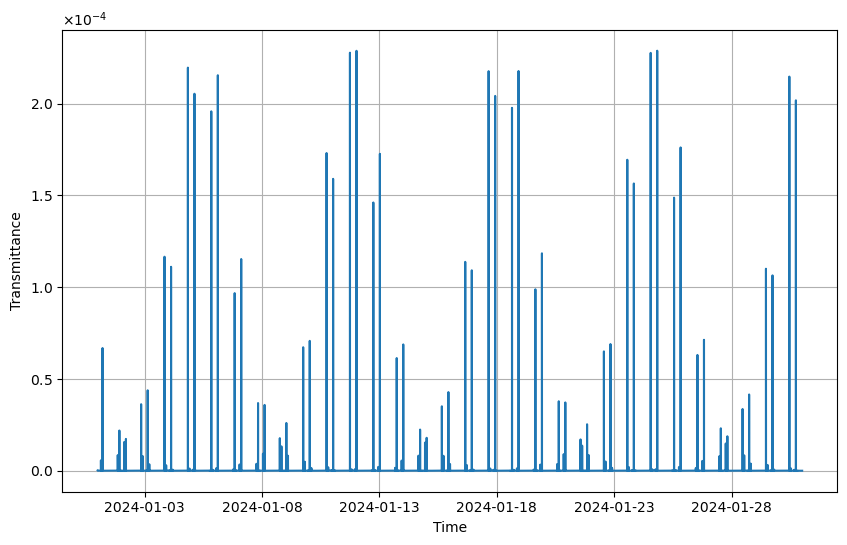

In [59]:
from matplotlib.ticker import MaxNLocator

# 使用科学计数法格式化 y 轴
plt.figure(figsize=(10, 6))
plt.plot(time_series, efficiency_history, label='link total efficiency')
plt.xlabel('Time')
plt.ylabel('Transmittance')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=7))
#plt.title('link efficiency between New York and Washington D.C.')
#plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

In [29]:
import numpy as np
#draw the distribution graph
# Step 1: Convert eta to dB, filtering out zeros first
eta_history_np = np.array(efficiency_history)
eta_nonzero = eta_history_np[eta_history_np > 0.00000000001]  # Filter out zero values
eta_dB = 10 * np.log10(eta_nonzero)  # Convert to dB

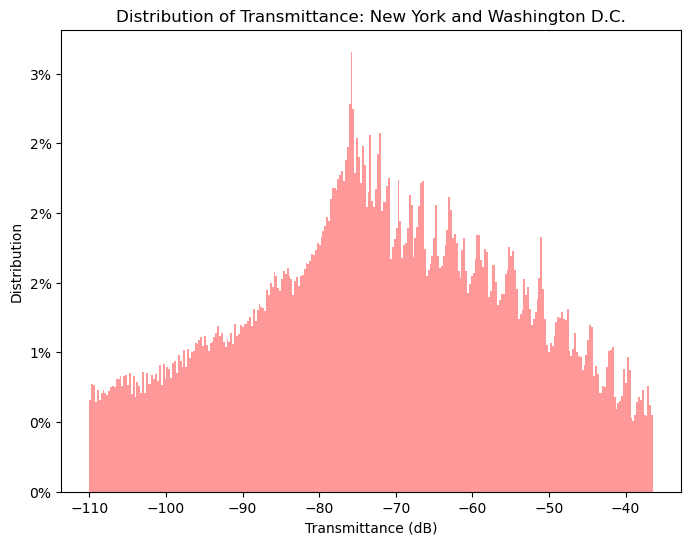

In [30]:
# Step 2: Plotting
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(eta_dB, bins=300, density=True, alpha=0.4, color='r')  # You can adjust bins for better visualization

# Convert y-axis to percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

plt.xlabel('Transmittance (dB)')
plt.ylabel('Distribution')
plt.title('Distribution of Transmittance: New York and Washington D.C.')
plt.grid(False)
plt.show()

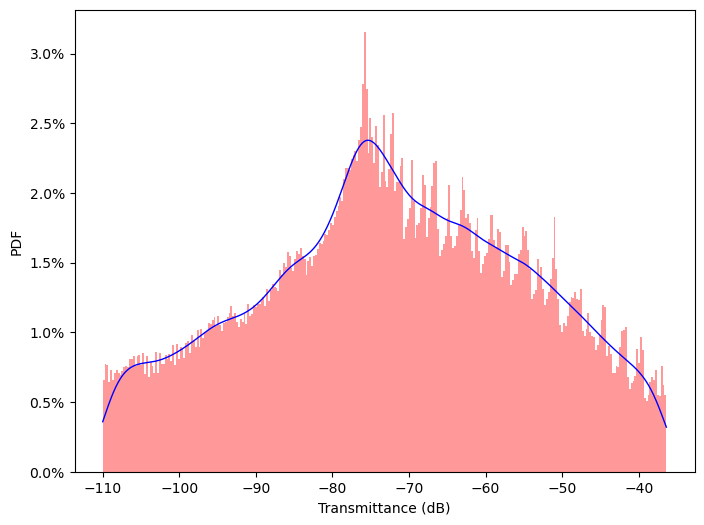

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Step 1: Calculate the Gaussian KDE for the data
kde = gaussian_kde(eta_dB, bw_method='scott')  # 'scott' or 'silverman' for bandwidth methods
x = np.linspace(min(eta_dB), max(eta_dB), 1000)  # Generate 1000 points between min and max of data
pdf = kde(x)  # Evaluate the PDF at each point

# Step 2: Plot the PDF
plt.figure(figsize=(8, 6))
plt.plot(x, pdf, color='b', lw=1, label='PDF')  # Plot the PDF

# Optional: Plot the histogram for comparison
n, bins, patches = plt.hist(eta_dB, bins=300, density=True, alpha=0.4, color='r')

# Convert y-axis to percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y * 100)))

plt.xlabel('Transmittance (dB)')
plt.ylabel('PDF')
#plt.title('PDF and Histogram of Transmittance: New York and Washington D.C.')
#plt.legend()
plt.grid(False)
plt.show()


In [26]:


# 提取有效时间窗口
def extract_valid_windows(data, threshold=0):
    # 找到大于阈值的索引
    indices = np.where(data > threshold)[0]
    # 通过对连续索引分组提取时间窗口
    windows = np.split(indices, np.where(np.diff(indices) != 1)[0] + 1)
    # 只返回长度大于0的窗口
    valid_windows = [window for window in windows if len(window) > 0]
    return valid_windows

# 使用提取函数
valid_windows = extract_valid_windows(efficiency_history)

# 输出结果查看
for i, window in enumerate(valid_windows[:10]):  # 只打印前5个窗口以示例
    print(f"Window {i+1}: Start {window[0]}, End {window[-1]}, Length {len(window)}")

Window 1: Start 0, End 294, Length 295
Window 2: Start 5730, End 6334, Length 605
Window 3: Start 11720, End 12426, Length 707
Window 4: Start 17694, End 18431, Length 738
Window 5: Start 23791, End 24160, Length 370
Window 6: Start 68058, End 68142, Length 85
Window 7: Start 73692, End 74367, Length 676
Window 8: Start 79649, End 80344, Length 696
Window 9: Start 85712, End 86321, Length 610
Window 10: Start 91760, End 92375, Length 616


# Quantum Simulation

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def create_bell_state():
    """Generate a Bell state |Φ+⟩ = (|00⟩ + |11⟩) / sqrt(2)."""
    return np.array([1, 0, 0, 1]) / np.sqrt(2)

def hadamard_transform(state):
    """Apply the Hadamard transform to a quantum state."""
    H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])
    return np.kron(H, H).dot(state)


def apply_noise(state, snr_db, loss_db):
    """
    Apply noise based on SNR in dB and simulate loss in dB.
    
    :param state: Quantum state represented as a numpy array.
    :param snr_db: Signal-to-Noise Ratio in decibels.
    :param loss_db: Loss in decibels.
    :return: Quantum state after noise and loss have been applied.
    """
    # Convert loss from dB to a linear scale factor
    loss_factor = 10 ** (-loss_db / 10)

    # Apply loss to the quantum state
    state_after_loss = state * loss_factor

    # Calculate the power of the state after loss
    signal_power = np.mean(np.abs(state_after_loss)**2)

    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)

    # Calculate noise power based on the signal power and linear SNR
    noise_power = signal_power / snr_linear

    # Generate Gaussian noise with calculated noise power
    noise = np.sqrt(noise_power) * (np.random.randn(*state.shape))

    # Add noise to the attenuated state
    noisy_state = state_after_loss + noise

    # Normalize the state to ensure it remains a valid quantum state
    noisy_state /= np.linalg.norm(noisy_state)

    return noisy_state

def eavesdrop(state):
    """Simulate Eve's random measurement in either the Z or X basis, affecting entanglement."""
    basis = np.random.choice(['Z', 'X'])
    if basis == 'Z':
        # Eve measures in Z basis, resulting state collapses randomly to |0⟩ or |1⟩ for one qubit
        if np.random.rand() > 0.5:
            # Collapse Alice's qubit to |0⟩
            state = np.array([1, 0, 0, 0]) if np.random.rand() > 0.5 else np.array([0, 1, 0, 0])
        else:
            # Collapse Alice's qubit to |1⟩
            state = np.array([0, 0, 1, 0]) if np.random.rand() > 0.5 else np.array([0, 0, 0, 1])
    else:
        # Eve measures in X basis, similarly collapse Alice's qubit randomly
        H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
        plus_state = np.array([1, 1, 1, 1]) / 2 if np.random.rand() > 0.5 else np.array([1, -1, 1, -1]) / 2
        minus_state = np.array([1, 1, -1, -1]) / 2 if np.random.rand() > 0.5 else np.array([1, -1, -1, 1]) / 2
        state = np.kron(H, np.eye(2)).dot(plus_state if np.random.rand() > 0.5 else minus_state)
    return state

def measure_state(state, basis_a, basis_b):
    """Measure a state in given bases for Alice and Bob."""
    if basis_a == 'X':
        state = np.kron(np.array([[1, 1], [1, -1]]) / np.sqrt(2), np.eye(2)).dot(state)
    if basis_b == 'X':
        state = np.kron(np.eye(2), np.array([[1, 1], [1, -1]]) / np.sqrt(2)).dot(state)
    probabilities = np.abs(state)**2
    results = ['00', '01', '10', '11']
    result_index = np.random.choice(len(results), p=probabilities)
    return int(results[result_index][0]), int(results[result_index][1])

def simulate_communication(num_bits, snr, loss, with_eve=False):
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits)
    bob_bases = np.random.choice(bases, num_bits)
    eve_bases = np.random.choice(bases, num_bits)

    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve and eve_bases[i]==alice_bases[i]:
            
            qubit = eavesdrop(qubit)
        #
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    return alice_bases, bob_bases, alice_results, bob_results

def calculate_qber(alice_bases, bob_bases, alice_results, bob_results):
    matching_bases_indices = np.where(alice_bases == bob_bases)[0]
    matching_bases_count = len(matching_bases_indices)
    if matching_bases_count == 0:
        return 0, 0
    
    error_count = sum(alice_results[i] != bob_results[i] for i in matching_bases_indices)
    qber = error_count / matching_bases_count
    key_generation_rate = matching_bases_count / len(alice_bases)
    return qber, key_generation_rate



In [9]:
def run_simulation(num_bits, num_trials, snr, loss):
    qber_no_eve = []
    qber_with_eve = []

    for _ in range(num_trials):
        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=False)
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        qber_no_eve.append(qber)

        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=True)
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        qber_with_eve.append(qber)

    return np.mean(qber_no_eve), np.mean(qber_with_eve)

# Parameters
num_bits = 10000
num_trials = 10
snr = 10
# Higher SNR means lower noise
loss = 0.2 # Lower loss means less attenuation

qber_no_eve, qber_with_eve = run_simulation(num_bits, num_trials, snr, loss)


In [11]:
def calculate_key_generation_rate(eta, R_source, QBER, QBER_threshold=0.11):
    """
    Calculate the key generation rate for quantum communication using E91 protocol,
    considering a QBER threshold.

    Parameters:
    eta (float): Transmission efficiency (0 <= eta <= 1)
    R_source (float): Photon pair emission rate per second from the quantum source
    QBER (float): Quantum Bit Error Rate (0 <= QBER <= 1)
    QBER_threshold (float): The maximum acceptable QBER for key generation (default is 0.11)

    Returns:
    float: Key generation rate in bits per second. Returns 0 if QBER is above the threshold.
    """
    # Check if QBER is within the acceptable range
    if QBER > QBER_threshold:
        return 0  # No key is generated if the QBER is too high

    # Calculate the raw key rate considering the transmission efficiency and the emission rate
    S_raw = 0.5 * eta * R_source  # 50% probability of choosing each basis
    
    # Calculate the final key rate considering the QBER
    key_generation_rate = S_raw * (1 - 2 * QBER)
    
    return key_generation_rate

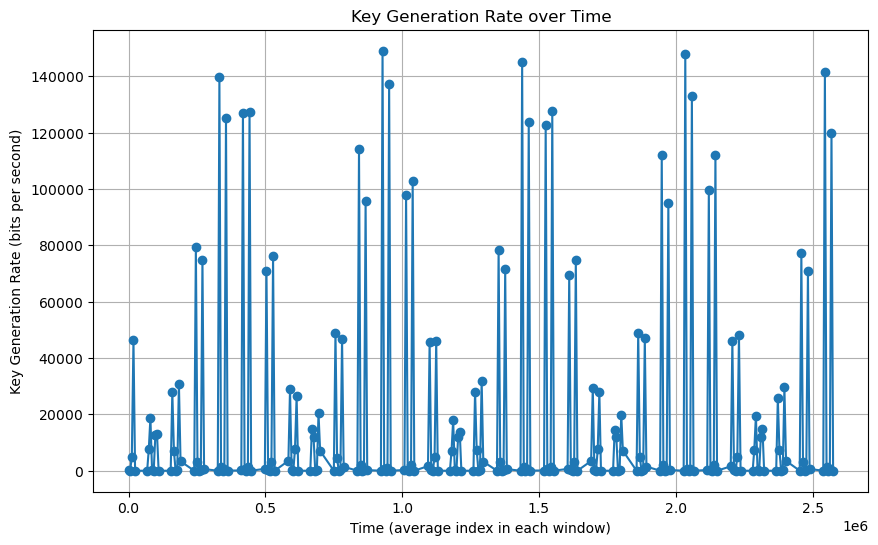

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 `valid_windows` 和 `efficiency_history` 为已提供的有效时间窗口和效率历史数据

# 假设的传输效率和源速率
R_source = 1e10  # 光子对每秒发射率
QBER_threshold = 0.11  # 可接受的最大QBER

# 计算在不同时间窗口的密钥生成率
key_generation_rates = []

for window in valid_windows:
    eta_avg = np.mean(efficiency_history[window])  # 计算平均传输效率
    # 模拟每个窗口的通信
    alice_bases, bob_bases, alice_results, bob_results = simulate_communication(len(window), snr=10, loss=eta_avg, with_eve=False)
    # 计算QBER
    qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
    #print(qber)
    # 计算密钥生成率
    key_rate = calculate_key_generation_rate(eta_avg, R_source, qber, QBER_threshold)
    key_generation_rates.append(key_rate)

# 可视化密钥生成率随时间的变化
plt.figure(figsize=(10, 6))
plt.plot([np.mean(window) for window in valid_windows], key_generation_rates, marker='o', linestyle='-')
plt.xlabel('Time (average index in each window)')
plt.ylabel('Key Generation Rate (bits per second)')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.title('Key Generation Rate over Time')
plt.grid(True)
plt.show()


# base line

In [5]:
import numpy as np

# 假设您已经有了 efficiency_history 数组


efficiency_history_file_path = 'dataset/efficiency_history_STARLINK-1094.npy' 

efficiency_history  = np.load(efficiency_history_file_path)

## Write the dictionary to a file in JSON format
#with open(efficiency_history_file_path, 'w') as file:
#    json.dump(efficiency_history, file)


# 提取有效时间窗口
def extract_valid_windows(data, threshold=0):
    # 找到大于阈值的索引
    indices = np.where(data > threshold)[0]
    # 通过对连续索引分组提取时间窗口
    windows = np.split(indices, np.where(np.diff(indices) != 1)[0] + 1)
    # 只返回长度大于0的窗口
    valid_windows = [window for window in windows if len(window) > 0]
    return valid_windows

# 使用提取函数
valid_windows = extract_valid_windows(efficiency_history)

# 输出结果查看
for i, window in enumerate(valid_windows[:10]):  # 只打印前5个窗口以示例
    print(f"Window {i+1}: Start {window[0]}, End {window[-1]}, Length {len(window)}")

Window 1: Start 0, End 294, Length 295
Window 2: Start 5730, End 6334, Length 605
Window 3: Start 11720, End 12426, Length 707
Window 4: Start 17694, End 18431, Length 738
Window 5: Start 23791, End 24160, Length 370
Window 6: Start 68058, End 68142, Length 85
Window 7: Start 73692, End 74367, Length 676
Window 8: Start 79649, End 80344, Length 696
Window 9: Start 85712, End 86321, Length 610
Window 10: Start 91760, End 92375, Length 616


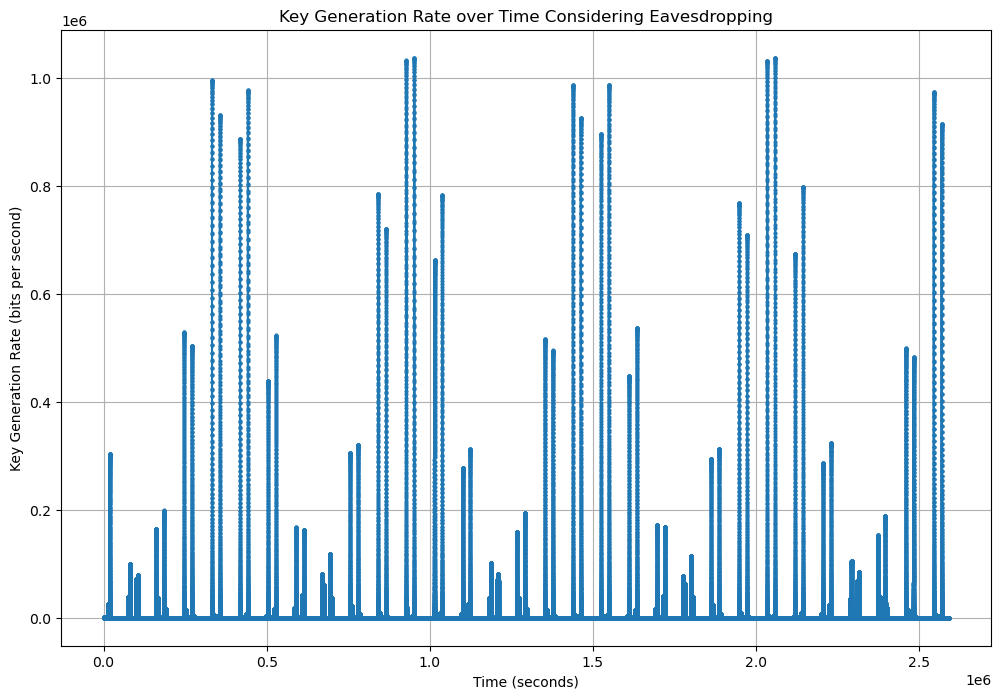

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 假设的传输效率和源速率
R_source = 10000000000  # 光子对每秒发射率
QBER_threshold = 0.11  # 可接受的最大QBER

# 初始化密钥生成率数组，长度与 efficiency_history 相同，初始值为零
all_key_rates = np.zeros(len(efficiency_history))

# 计算一个时间窗口内的密钥生成率，并更新 all_key_rates 数组np.load
def update_window_key_rates(window, efficiency_history, qber, R_source, QBER_threshold, all_key_rates):
    for second in window:
        eta = efficiency_history[second]  # 获取当前秒的效率
        # 计算密钥生成率
        key_rate = calculate_key_generation_rate(eta, R_source, qber, QBER_threshold)
        all_key_rates[second] = key_rate  # 更新密钥生成率数组

# 遍历所有有效时间窗口并更新密钥生成率
for window in valid_windows:
    update_window_key_rates(window, efficiency_history, qber_no_eve, R_source, QBER_threshold, all_key_rates)

# 可视化密钥生成率随时间的变化
plt.figure(figsize=(12, 8))
plt.plot(all_key_rates, marker='o', linestyle='-', markersize=2)
plt.xlabel('Time (seconds)')

plt.ylabel('Key Generation Rate (bits per second)')
plt.title('Key Generation Rate over Time Considering Eavesdropping')
plt.grid(True)
plt.show()


In [24]:
specific_time = datetime(2024, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
start_time = specific_time
end_time = specific_time+timedelta(days = 30)

time_step = timedelta(seconds = 1)

time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step )]

Total keys generated over the period: 3299547644.88 bits


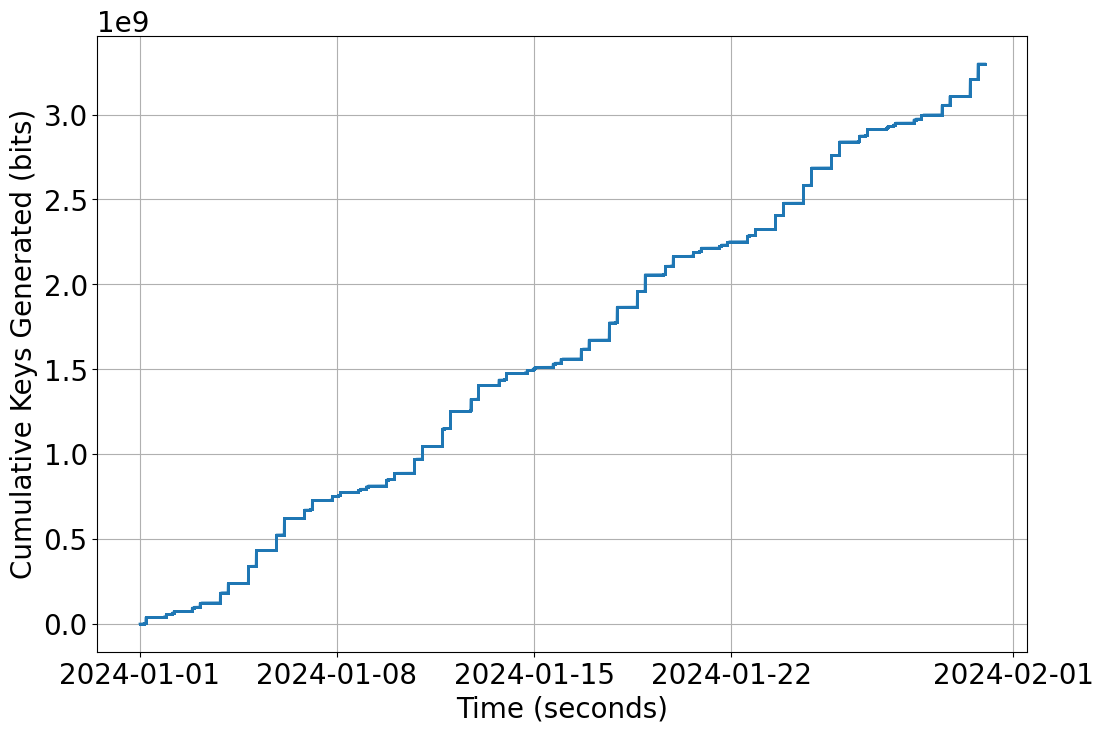

In [58]:
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
# 计算累积生成密钥的数量
cumulative_keys_generated = np.cumsum(all_key_rates)
print(f"Total keys generated over the period: {cumulative_keys_generated[-1]:.2f} bits")



# 可视化累积生成密钥的数量随时间的变化
plt.figure(figsize=(12, 8))
plt.plot(time_series, cumulative_keys_generated, marker='o', linestyle='-', markersize=1, label='Cumulative Keys Generated (bits)')
plt.xlabel('Time (seconds)')
plt.ylabel('Cumulative Keys Generated (bits)')

# Use AutoDateLocator and AutoDateFormatter for better date handling
locator = mdates.AutoDateLocator(minticks=6, maxticks=6)
formatter = mdates.AutoDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

#plt.title('Cumulative Keys Generated over Time')
#plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 20})
plt.show()

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 假设的传输效率和源速率
R_source = 1e10  # 光子对每秒发射率
QBER_threshold = 0.11  # 可接受的最大QBER

def simulate_key_rates(listening_frequency, valid_windows, efficiency_history, qber_no_eve, qber_with_eve, R_source):
    # 初始化密钥生成率数组，长度与 efficiency_history 相同，初始值为零
    all_key_rates = np.zeros(len(efficiency_history))
    
    # 遍历所有有效时间窗口并根据监听频率更新密钥生成率
    for window in valid_windows:
        if random.random() < listening_frequency:  # 随机决定是否监听
            qber = qber_with_eve
        else:
            qber = qber_no_eve
        
        # 更新窗口内的密钥生成率
        for second in window:
            eta = efficiency_history[second]  # 获取当前秒的效率
            key_rate = calculate_key_generation_rate(eta, R_source, qber, QBER_threshold)
            all_key_rates[second] = key_rate  # 更新密钥生成率数组

    return np.cumsum(all_key_rates)  # 返回累积生成的密钥数

# 设置监听频率
listening_frequencies = [0, 0.25, 0.5, 0.75, 1.0]



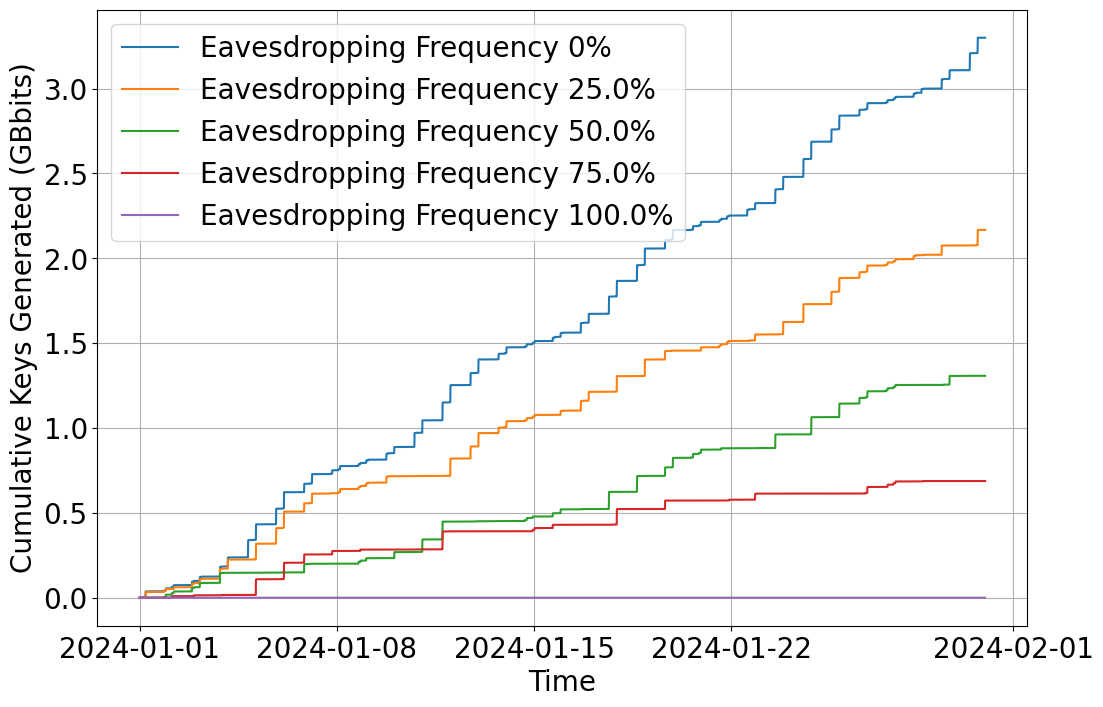

In [62]:
# 准备绘图
plt.figure(figsize=(12, 8))

for freq in listening_frequencies:
    cumulative_keys = simulate_key_rates(freq, valid_windows, efficiency_history, qber_no_eve, qber_with_eve, R_source)
    plt.plot(time_series, cumulative_keys/1e9, label=f'Eavesdropping Frequency {freq*100}%')

plt.xlabel('Time')
plt.ylabel('Cumulative Keys Generated (GBbits)')

# Use AutoDateLocator and AutoDateFormatter for better date handling
locator = mdates.AutoDateLocator(minticks=6, maxticks=6)
formatter = mdates.AutoDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()
#plt.title('Cumulative Keys Generated over Time')
#plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 20})
plt.show()

# Experiment 2, hide

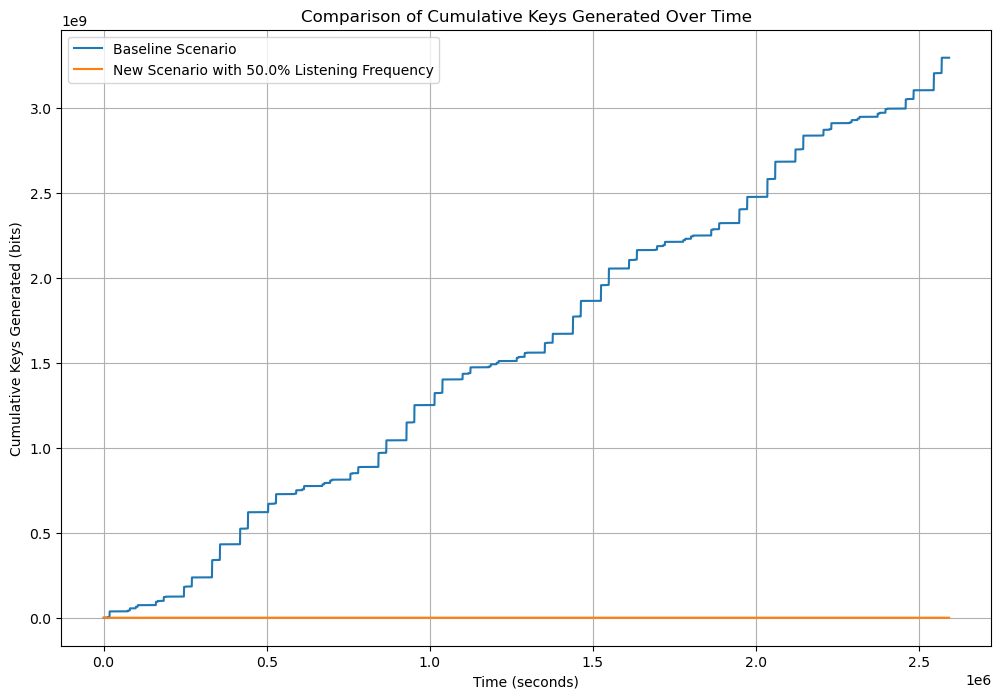

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 假设的传输效率和源速率，和之前一样
R_source = 1000  # 光子对每秒发射率
QBER_threshold = 0.11  # 可接受的最大QBER

# 实验新参数，比如新的监听频率或QBER阈值
new_listening_frequency = 0.50  # 假设新的实验中监听频率为50%

# 更新密钥生成率的函数，考虑新的监听频率
def update_window_key_rates_new(window, efficiency_history, qber_no_eve, qber_with_eve, R_source, listening_frequency, all_key_rates):
    for second in window:
        if random.random() < listening_frequency:  # 根据新的监听频率决定是否监听
            qber = qber_with_eve
        else:
            qber = qber_no_eve
        eta = efficiency_history[second]
        key_rate = calculate_key_generation_rate(eta, R_source, qber, QBER_threshold)
        all_key_rates[second] = key_rate

# 运行新的实验
all_key_rates_new = np.zeros(len(efficiency_history))
for window in valid_windows:
    update_window_key_rates_new(window, efficiency_history, qber_no_eve, qber_with_eve, R_source, new_listening_frequency, all_key_rates_new)

# 计算累积密钥生成
cumulative_keys_generated_new = np.cumsum(all_key_rates_new)

# 可视化比较基线和新实验场景
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(all_key_rates), label='Baseline Scenario')
plt.plot(cumulative_keys_generated_new, label=f'New Scenario with {new_listening_frequency*100}% Listening Frequency')
plt.xlabel('Time (seconds)')
plt.ylabel('Cumulative Keys Generated (bits)')
plt.title('Comparison of Cumulative Keys Generated Over Time')
plt.legend()
plt.grid(True)
plt.show()


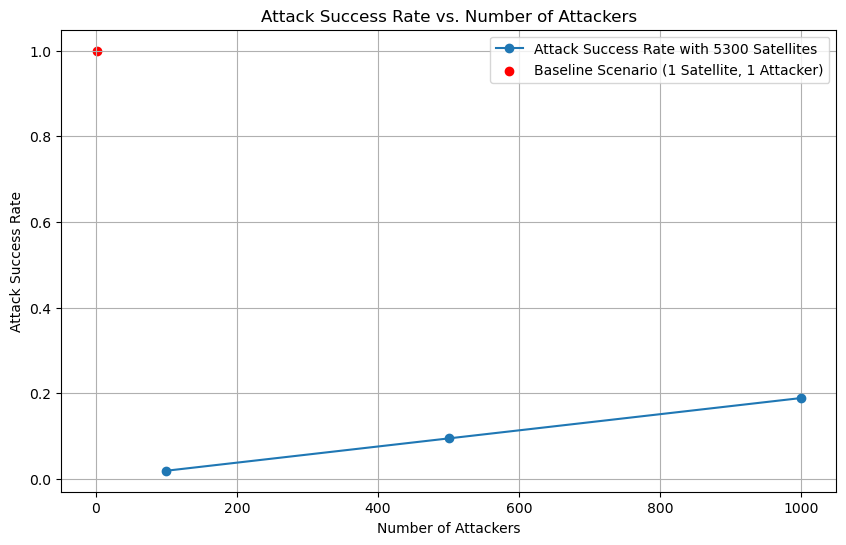

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 设定卫星总数和攻击者数量
total_satellites = 5300
attackers_counts = [100, 500, 1000]

# 计算每种攻击者情况下的攻击成功频率
attack_success_rates = [attackers * 1 / total_satellites for attackers in attackers_counts]

# 基线情况：1个卫星和1个攻击者
baseline_attack_success_rate = 1 * 1 / 1

# 运行模拟并绘制结果
plt.figure(figsize=(10, 6))
plt.plot(attackers_counts, attack_success_rates, marker='o', linestyle='-', label='Attack Success Rate with 5300 Satellites')
plt.scatter([1], [baseline_attack_success_rate], color='red', label='Baseline Scenario (1 Satellite, 1 Attacker)')
plt.xlabel('Number of Attackers')
plt.ylabel('Attack Success Rate')
plt.title('Attack Success Rate vs. Number of Attackers')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 假设的传输效率和源速率
R_source = 1e10  # 光子对每秒发射率
QBER_threshold = 0.11  # 可接受的最大QBER

# 卫星总数和攻击者数量
total_satellites = 5000
attackers_counts = [0, 250, 500, 1000, 1500]  # 不同的攻击者数量

# 计算攻击成功频率
listening_frequencies = [attackers / total_satellites for attackers in attackers_counts]

# 添加基线情况，其中只有一个卫星和一个攻击者
baseline_frequency = [1]  # 100%监听频率，因为只有1个攻击者和1个卫星

# 合并所有监听频率
listening_frequencies = baseline_frequency + listening_frequencies

def simulate_key_rates(listening_frequency, valid_windows, efficiency_history, qber_no_eve, qber_with_eve, R_source):
    all_key_rates = np.zeros(len(efficiency_history))
    for window in valid_windows:
        if random.random() < listening_frequency:
            qber = qber_with_eve
        else:
            qber = qber_no_eve
        for second in window:
            eta = efficiency_history[second]
            key_rate = calculate_key_generation_rate(eta, R_source, qber, QBER_threshold)
            all_key_rates[second] = key_rate
    return np.cumsum(all_key_rates)




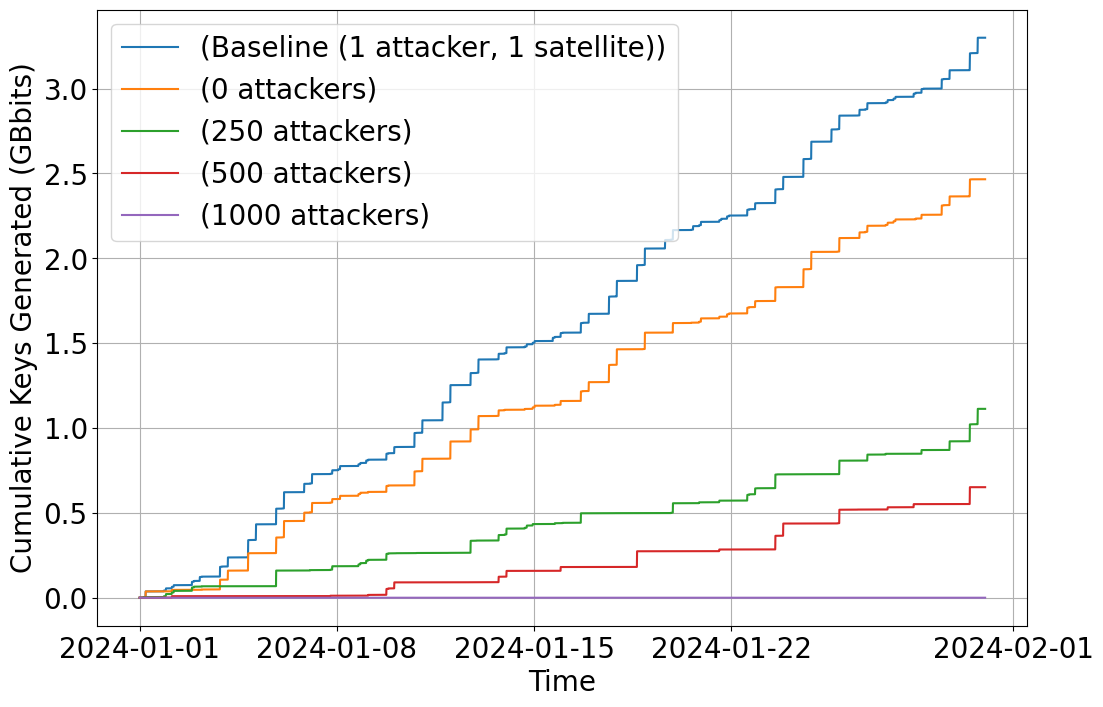

In [61]:
# 准备绘图
plt.figure(figsize=(12, 8))
labels = ['Baseline (1 attacker, 1 satellite)'] + [f'{count} attackers' for count in attackers_counts]
for freq, label in zip(listening_frequencies, labels):
    #print(freq)
    cumulative_keys = simulate_key_rates(freq, valid_windows, efficiency_history, qber_no_eve, qber_with_eve, R_source)
    plt.plot(time_series, cumulative_keys/1e9, label=f'({label})')

plt.xlabel('Time')
plt.ylabel('Cumulative Keys Generated (GBbits)')
# Use AutoDateLocator and AutoDateFormatter for better date handling
locator = mdates.AutoDateLocator(minticks=6, maxticks=6)
formatter = mdates.AutoDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()
#plt.title('Cumulative Keys Generated over Time')
#plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 20})
plt.show()

In [38]:
# 配置参数
total_satellites = 5300
attackers_counts = [0, 1500]  # 包含0攻击者的情况用作基线
listening_frequencies = [attackers / total_satellites for attackers in attackers_counts]

# 模拟每种监听频率下的密钥生成
cumulative_keys_dict = {}
for freq, attackers in zip(listening_frequencies, attackers_counts):
    cumulative_keys = simulate_key_rates(freq, valid_windows, efficiency_history, qber_no_eve, qber_with_eve, R_source)
    cumulative_keys_dict[attackers] = cumulative_keys  # 存储每种情况的最终累积密钥数量

# 计算损失的密钥数量和百分比
baseline_keys = cumulative_keys_dict[0]  # 0攻击者的情况
losses = {}
for attackers in attackers_counts[0:]:  # 除去基线情况
    lost_keys = baseline_keys - cumulative_keys_dict[attackers]
    loss_percentage = (lost_keys / baseline_keys[-1]) * 100
    losses[attackers] = (lost_keys, loss_percentage)

# 输出损失结果
for attackers, (lost_keys, loss_percentage) in losses.items():
    print(f"Loss with {attackers} attackers: {lost_keys[-1]:.2f} keys lost, {loss_percentage[-1]:.2f}% loss")



Loss with 0 attackers: 0.00 keys lost, 0.00% loss
Loss with 1500 attackers: 527031907.59 keys lost, 15.98% loss


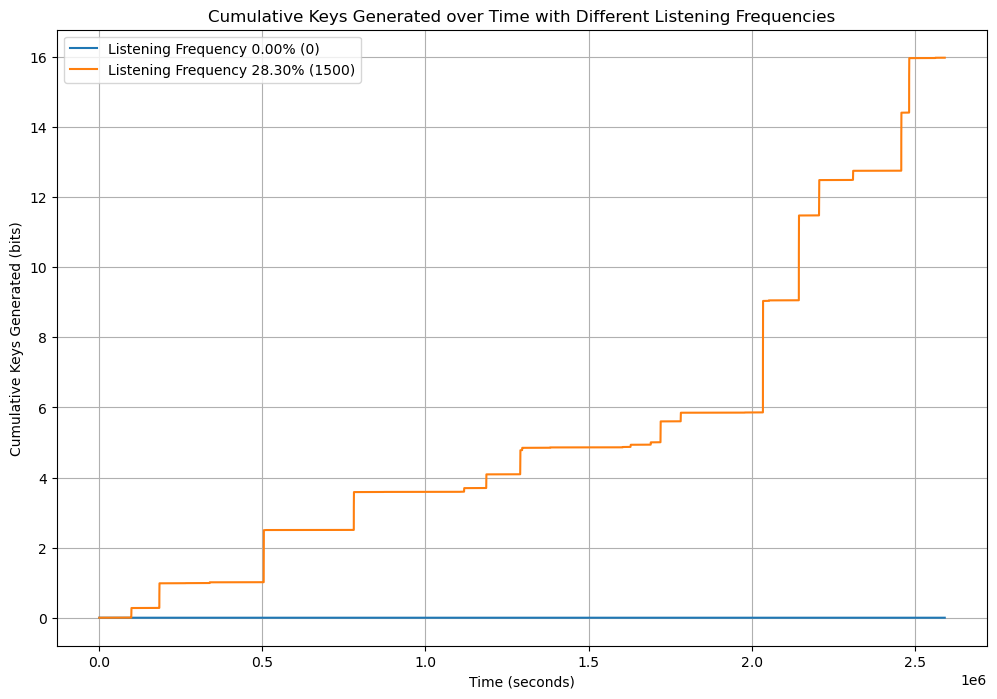

In [39]:
# 准备绘图
plt.figure(figsize=(12, 8))
labels = [f'{count} attackers' for count in attackers_counts]
for freq, label in zip(listening_frequencies, attackers_counts):
    #print(freq)
    plt.plot(losses[label][1], label=f'Listening Frequency {freq*100:.2f}% ({label})')

plt.xlabel('Time (seconds)')
plt.ylabel('Cumulative Keys Generated (bits)')
plt.title('Cumulative Keys Generated over Time with Different Listening Frequencies')
plt.legend()
plt.grid(True)
plt.show()

# Experiment 3

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# 假定已经定义了以下函数和数据结构
# communication_loss_stat2sat, optimal_constellation_entity, ground_stations_entity, ts

# 设定时间参数
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)
start_time = specific_time
end_time = specific_time + 30  # 30天后
time_steps = 30 * 1440 * 60  # 每秒一个时间步长

# 定义卫星列表
satellites = ['STARLINK-1094', 'STARLINK-1102', 'STARLINK-1144', 'STARLINK-1156']
satellite_data = {}
valid_windows_dict = {}  # 创建一个字典来存储每颗卫星的有效时间窗口

# 循环每个卫星，获取效率历史
for sat in satellites:
    print("Satellite: "+sat)
    current_time = start_time
    efficiency_history = []
    for _ in range(time_steps):
        # 更新卫星时间
        optimal_constellation_entity[sat].change_time(current_time)
        # 重新计算链路效率
        eta_total = communication_loss_stat2sat(ground_stations_entity['New York'], optimal_constellation_entity[sat]) * communication_loss_stat2sat(ground_stations_entity['Washington D.C.'], optimal_constellation_entity[sat])
        efficiency_history.append(eta_total)
        current_time += (end_time - start_time) / time_steps

    # 加载效率历史数据
    file_path = f'./dataset/efficiency_history_{sat}.json'
    efficiency_history = np.array(efficiency_history)  # 转换为 numpy 数组以便处理
    np.save(file_path, efficiency_history)
    #with open(file_path, 'w') as file:
        #json.dump(efficiency_history, file)
        #efficiency_history = json.load(file)
        #efficiency_history = np.array(efficiency_history)  # 转换为 numpy 数组以便处理
    
    # 转换为 numpy 数组并存储
    satellite_data[sat] = efficiency_history
    # 提取有效时间窗口并存储
    valid_windows_dict[sat] = extract_valid_windows(satellite_data[sat])



Satellite: STARLINK-1094
Satellite: STARLINK-1102
Satellite: STARLINK-1144
Satellite: STARLINK-1156


In [ ]:
satellite_tle_data = parse_tle(tle_path)

In [73]:
import numpy as np
import random

def simulate_key_rates_with_adjusted_windows(valid_windows_dict, satellite_data, qber_no_eve, qber_with_eve, R_source, satellite_tle_data, primary_satellite='STARLINK-1094', total_attackers=1500):
    total_satellites = len(satellite_data)
    all_key_rates = np.zeros(len(satellite_data[primary_satellite]))

    def attempt_reshedule(current_satellite, already_searched, start_time):
        
        current_windows = valid_windows_dict[current_satellite]
        for window in current_windows:
            targeted_satellites = random.sample(list(satellite_tle_data), total_attackers)
            window_start = window[0]
            #if window_start < start_time:
                #continue  # Skip windows that start before the rescheduling point

            if current_satellite in targeted_satellites:
                can_switch, new_satellite = can_switch_to_another_satellite(window_start , valid_windows_dict, current_satellite, already_searched)
                if can_switch:
                    print(f"Switching from {current_satellite} to {new_satellite} at second {window_start + 30}")
                    new_start_time = max(window_start + 30, valid_windows_dict[new_satellite][0][0])
                    return attempt_reshedule(new_satellite, already_searched | {new_satellite}, new_start_time)
                else:
                    qber = qber_with_eve  # No available satellite to switch or all are monitored
            else:
                qber = qber_no_eve  # Current satellite not targeted

            # Update key rates for the current window starting from new_start_time
            for second in range(max(window_start, start_time), window[-1] + 1):
                eta = satellite_data[current_satellite][second]
                key_rate = calculate_key_generation_rate(eta, R_source, qber, QBER_threshold)
                all_key_rates[second] = key_rate

        return np.cumsum(all_key_rates)  # Return cumulative key rates

    # Start the simulation with the initial satellite and an empty set for already searched satellites
    return attempt_reshedule(primary_satellite, set(), 0)

def can_switch_to_another_satellite(start_second, valid_windows_dict, current_satellite, already_searched):
    switch_time_start = start_second + 30
    switch_time_end = start_second + 60
    for sat, windows in valid_windows_dict.items():
        if sat == current_satellite or sat in already_searched:
            continue
        for window in windows:
            window_start = window[0]
            window_end = window[-1]
            if window_start <= switch_time_end and window_end >= switch_time_start:
                return True, sat
    return False, None

# Assuming the other necessary functions and variables are defined as needed.
cumulative_keys = simulate_key_rates_with_adjusted_windows(valid_windows_dict, satellite_data, qber_no_eve, qber_with_eve, R_source, satellite_tle_data, primary_satellite='STARLINK-1094', total_attackers=1500)


Switching from STARLINK-1094 to STARLINK-1102 at second 5760
Switching from STARLINK-1102 to STARLINK-1144 at second 5638
Switching from STARLINK-1144 to STARLINK-1094 at second 245796
Switching from STARLINK-1094 to STARLINK-1156 at second 153975


In [69]:
 random.sample(list(satellite_data.keys()), total_attackers)

NameError: name 'total_attackers' is not defined

In [70]:
satellite_data

{'STARLINK-1094': array([1.51480670e-07, 1.50934659e-07, 1.50347392e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'STARLINK-1102': array([5.84588152e-09, 5.71584594e-09, 5.58614577e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'STARLINK-1144': array([1.56290640e-06, 1.50684493e-06, 1.45246284e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'STARLINK-1156': array([2.24588193e-08, 2.34701816e-08, 2.45168801e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00])}

In [74]:
qber_no_eve

0.04701263776794191

In [75]:
R_source


10000000000.0